/tmp/ipykernel_593233/1327932002.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


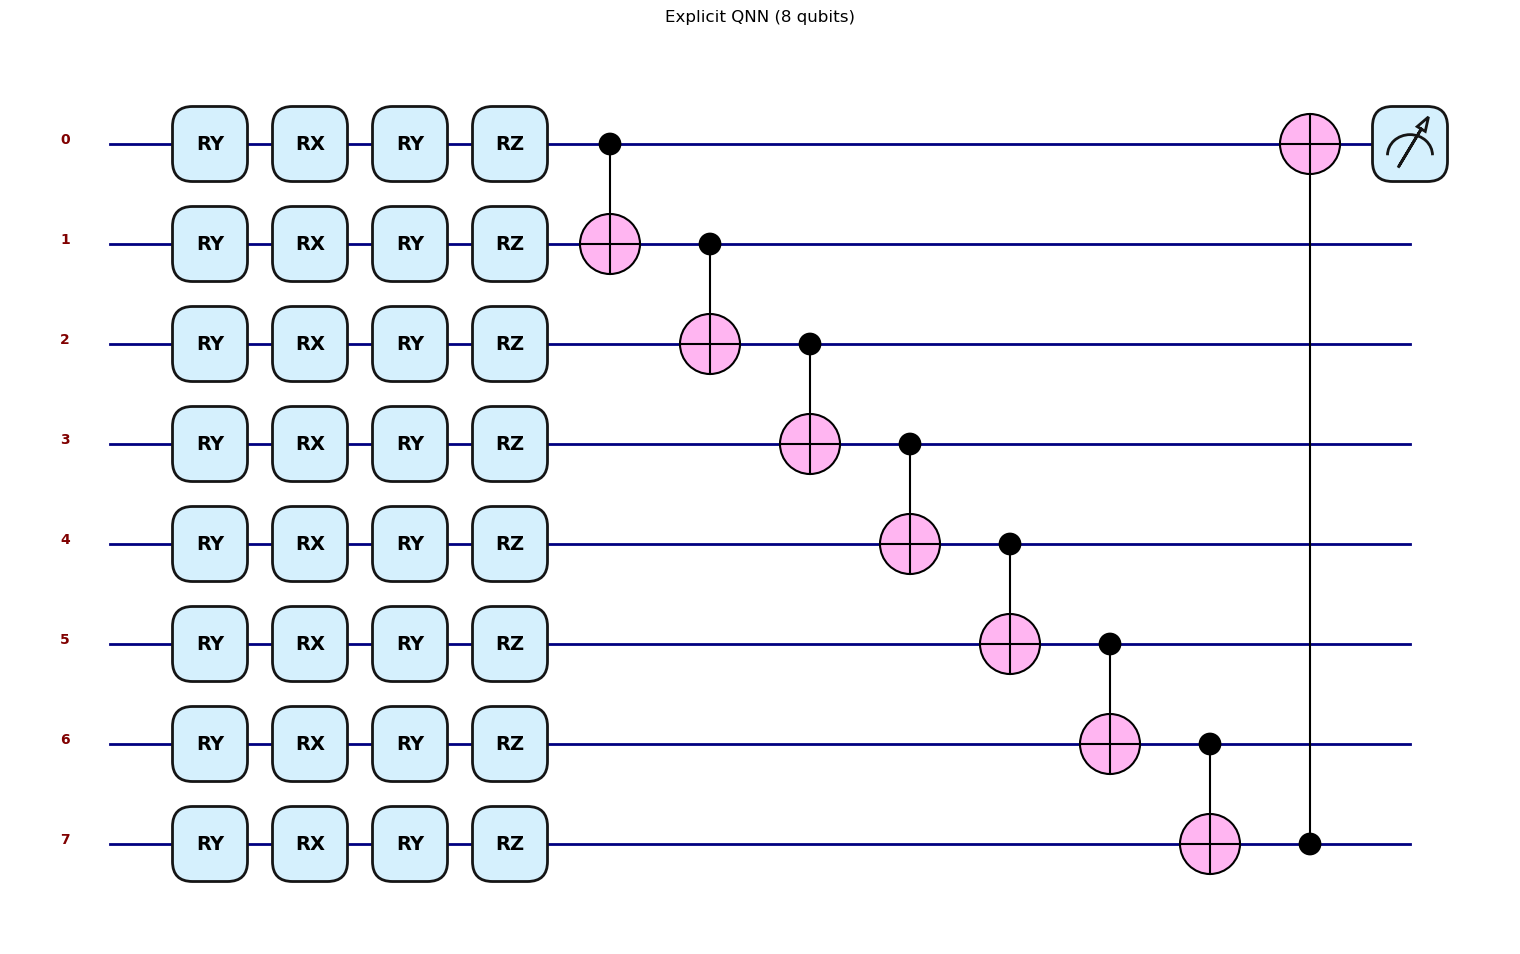

KeyboardInterrupt: 

In [3]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 数据加载与 PCA 降维
X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True, as_frame=False)
mask = (y == "0") | (y == "1")
X, y = X[mask] / 255 * np.pi, y[mask].astype(int)

n_features = 8
pca = PCA(n_components=n_features)
X_reduced = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

# 回路参数
n_qubits = n_features
n_layers = 1

dev = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def explicit_qnn(x, weights):
    # —— RY(x) 编码 —— 
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    # —— 可训练旋转 + 环形 CNOT —— 
    for i in range(n_qubits):
        qml.RX(weights[0, i, 0], wires=i)
        qml.RY(weights[0, i, 1], wires=i)
        qml.RZ(weights[0, i, 2], wires=i)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i + 1) % n_qubits])
    return qml.expval(qml.PauliZ(0))

# 初始化 & 训练
np.random.seed(1)
weights_exp = np.random.normal(0, np.pi, (n_layers, n_qubits, 3), requires_grad=True)
opt_exp = qml.GradientDescentOptimizer(stepsize=0.1)

# 彩色电路图
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(
    explicit_qnn,
    wire_order=range(n_qubits),
    show_all_wires=True,
    style="pennylane",
    wire_options={"color": "navy", "linewidth": 2},
    label_options={"size": 10, "color": "maroon"},
)(X_train[0], weights_exp)
ax.set_title("Explicit QNN (8 qubits)", pad=16)
plt.tight_layout()
plt.show()

def loss_exp(w):
    preds = np.array([explicit_qnn(x, w) for x in X_train])
    return np.mean((preds - (1 - 2 * y_train))**2)

for epoch in range(1, 11):
    weights_exp, loss = opt_exp.step_and_cost(loss_exp, weights_exp)
    tr_acc = np.mean((np.array([explicit_qnn(x, weights_exp) for x in X_train])>0) == (y_train==0))
    te_acc = np.mean((np.array([explicit_qnn(x, weights_exp) for x in X_test ])>0) == (y_test ==0))
    print(f"[Explicit] Epoch {epoch:2d}  loss={loss:.4f}  train_acc={tr_acc:.3f}  test_acc={te_acc:.3f}")
